🧱 **PHASE 1**: *Setup and Data Collection*

# 🏨 COMPREHENSIVE HOTEL BOOKING ANALYSIS
# =======================================
# End-to-End Data Science Project
# From Raw Data to Business Insights and Model Deployment

"""
PROJECT OVERVIEW:
================
This notebook analyzes hotel booking data to:
1. Understand booking patterns and customer behavior
2. Predict booking cancellations
3. Provide actionable business insights
4. Create a deployable prediction system

BUSINESS QUESTIONS:
==================
- What factors drive booking cancellations?
- How can we identify high-risk bookings?
- What are the seasonal and market trends?
- How can hotels optimize their booking strategy?
"""



# =============================================================================
# 📦 SECTION 0: SETUP AND IMPORTS
# =============================================================================


In [24]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, roc_auc_score, roc_curve, 
                           precision_recall_curve, f1_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("🚀 Hotel Booking Analysis - Comprehensive End-to-End Project")
print("=" * 60)


🚀 Hotel Booking Analysis - Comprehensive End-to-End Project



# =============================================================================
# 📁 SECTION 1: DATA LOADING AND INITIAL EXPLORATION
# =============================================================================


In [ ]:

def load_and_explore_data(file_path):
    """Load data and perform initial exploration"""
    print("\n📊 LOADING AND EXPLORING DATA")
    print("-" * 40)
    
    # Load data
    try:
        df = pd.read_csv(file_path)
        print(f"✅ Data loaded successfully!")
        print(f"📋 Dataset shape: {df.shape}")
    except FileNotFoundError:
        print("❌ File not found. Please check the file path.")
        return None
    
    # Basic information
    print(f"\n🔍 BASIC INFORMATION:")
    print(f"   • Rows: {df.shape[0]:,}")
    print(f"   • Columns: {df.shape[1]}")
    print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Data types
    print(f"\n📊 DATA TYPES:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   • {dtype}: {count} columns")
    
    # Missing values
    print(f"\n🕳️  MISSING VALUES:")
    missing_data = df.isnull().sum()
    missing_pct = (missing_data / len(df)) * 100
    
    missing_summary = pd.DataFrame({
        'Column': missing_data.index,
        'Missing_Count': missing_data.values,
        'Missing_Percentage': missing_pct.values
    }).sort_values('Missing_Percentage', ascending=False)
    
    # Only show columns with missing values
    missing_with_nulls = missing_summary[missing_summary['Missing_Count'] > 0]
    if not missing_with_nulls.empty:
        print(missing_with_nulls.to_string(index=False))
    else:
        print("   ✅ No missing values found!")
    
    # Duplicates
    duplicates = df.duplicated().sum()
    print(f"\n🔄 DUPLICATES: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")
    
    # Unique values in categorical columns
    print(f"\n🏷️  CATEGORICAL COLUMNS CARDINALITY:")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols[:10]:  # Show first 10
        unique_count = df[col].nunique()
        print(f"   • {col}: {unique_count} unique values")
    
    return df


In [26]:

# Load the data
# UPDATE THIS PATH TO YOUR DATA LOCATION
data = r"D:\Projects\Hotel Booking Analysis\data"
df = pd.read_csv(fr"{data}\hotel_bookings.csv")

if df is not None:
    # Display first few rows
    print(f"\n📋 FIRST 5 ROWS:")
    print(df.head())
    
    # Target variable distribution
    if 'is_canceled' in df.columns:
        cancel_rate = df['is_canceled'].mean()
        print(f"\n🎯 TARGET VARIABLE (is_canceled):")
        print(f"   • Cancellation Rate: {cancel_rate:.1%}")
        print(f"   • Canceled: {df['is_canceled'].sum():,}")
        print(f"   • Not Canceled: {(len(df) - df['is_canceled'].sum()):,}")



📋 FIRST 5 ROWS:
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     0       2       0.0   

In [30]:

# =============================================================================
# 🧹 SECTION 2: DATA CLEANING AND PREPROCESSING
# =============================================================================

def clean_data(df):
    """Comprehensive data cleaning"""
    print("\n🧹 DATA CLEANING")
    print("-" * 40)
    
    # Create a copy to avoid modifying original
    df_clean = df.copy()
    initial_shape = df_clean.shape
    
    # 1. Handle missing values strategically
    print("1️⃣ Handling missing values...")
    
    # Agent: Fill with 'Direct' (no agent)
    if 'agent' in df_clean.columns:
        df_clean['agent'].fillna('Direct', inplace=True)
        print("   ✅ Filled 'agent' missing values with 'Direct'")
    
    # Company: Fill with 'Individual' (no company booking)
    if 'company' in df_clean.columns:
        df_clean['company'].fillna('Individual', inplace=True)
        print("   ✅ Filled 'company' missing values with 'Individual'")
    
    # Children: Fill with 0 (assume no children if not specified)
    if 'children' in df_clean.columns:
        df_clean['children'].fillna(0, inplace=True)
        print("   ✅ Filled 'children' missing values with 0")
    
    # Country: Fill with 'Unknown'
    if 'country' in df_clean.columns:
        df_clean['country'].fillna('Unknown', inplace=True)
        print("   ✅ Filled 'country' missing values with 'Unknown'")
    
    # 2. Remove duplicates
    print("\n2️⃣ Removing duplicates...")
    duplicates_before = df_clean.duplicated().sum()
    df_clean.drop_duplicates(inplace=True)
    duplicates_after = df_clean.duplicated().sum()
    print(f"   ✅ Removed {duplicates_before:,} duplicate rows")
    
    # 3. Data type conversions and feature engineering
    print("\n3️⃣ Feature engineering...")
    
    # Create arrival date
    if all(col in df_clean.columns for col in ['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']):
        df_clean['arrival_date'] = pd.to_datetime(
            df_clean['arrival_date_year'].astype(str) + '-' +
            df_clean['arrival_date_month'] + '-' +
            df_clean['arrival_date_day_of_month'].astype(str)
        )
        print("   ✅ Created 'arrival_date' feature")
    
    # Total nights stayed
    if 'stays_in_weekend_nights' in df_clean.columns and 'stays_in_week_nights' in df_clean.columns:
        df_clean['total_nights'] = df_clean['stays_in_weekend_nights'] + df_clean['stays_in_week_nights']
        print("   ✅ Created 'total_nights' feature")
    
    # Total guests
    guest_cols = ['adults', 'children', 'babies']
    if all(col in df_clean.columns for col in guest_cols):
        df_clean['total_guests'] = df_clean[guest_cols].sum(axis=1)
        df_clean['total_guests'] = df_clean['total_guests'].replace(0, 1)  # Avoid division by zero
        print("   ✅ Created 'total_guests' feature")
    
    # Revenue per guest
    if 'adr' in df_clean.columns and 'total_guests' in df_clean.columns:
        df_clean['revenue_per_guest'] = df_clean['adr'] / df_clean['total_guests']
        print("   ✅ Created 'revenue_per_guest' feature")
    
    # Total revenue
    if 'adr' in df_clean.columns and 'total_nights' in df_clean.columns:
        df_clean['total_revenue'] = df_clean['adr'] * df_clean['total_nights']
        print("   ✅ Created 'total_revenue' feature")
    
    # Lead time categories
    if 'lead_time' in df_clean.columns:
        df_clean['lead_time_category'] = pd.cut(
            df_clean['lead_time'], 
            bins=[-1, 0, 30, 90, 365, np.inf],
            labels=['Same_Day', 'Short_Term', 'Medium_Term', 'Long_Term', 'Very_Long_Term']
        )
        print("   ✅ Created 'lead_time_category' feature")
    
    # Booking season
    if 'arrival_date' in df_clean.columns:
        df_clean['arrival_month'] = df_clean['arrival_date'].dt.month
        df_clean['season'] = df_clean['arrival_month'].map({
            12: 'Winter', 1: 'Winter', 2: 'Winter',
            3: 'Spring', 4: 'Spring', 5: 'Spring',
            6: 'Summer', 7: 'Summer', 8: 'Summer',
            9: 'Fall', 10: 'Fall', 11: 'Fall'
        })
        print("   ✅ Created 'season' feature")
    
    # Special requests indicator
    if 'total_of_special_requests' in df_clean.columns:
        df_clean['has_special_requests'] = (df_clean['total_of_special_requests'] > 0).astype(int)
        print("   ✅ Created 'has_special_requests' feature")
    
    # 4. Remove extreme outliers
    print("\n4️⃣ Handling outliers...")
    
    # Remove bookings with unrealistic values
    outlier_conditions = []
    
    if 'adr' in df_clean.columns:
        # Remove negative ADR and extremely high ADR (likely errors)
        outlier_conditions.append((df_clean['adr'] < 0) | (df_clean['adr'] > 5000))
    
    if 'lead_time' in df_clean.columns:
        # Remove extremely long lead times (likely errors)
        outlier_conditions.append(df_clean['lead_time'] > 1000)
    
    if 'total_guests' in df_clean.columns:
        # Remove bookings with too many guests (likely errors)
        outlier_conditions.append(df_clean['total_guests'] > 20)
    
    if outlier_conditions:
        outlier_mask = np.logical_or.reduce(outlier_conditions)
        outliers_removed = outlier_mask.sum()
        df_clean = df_clean[~outlier_mask]
        print(f"   ✅ Removed {outliers_removed:,} outlier records")
    
    # Summary
    final_shape = df_clean.shape
    print(f"\n📊 CLEANING SUMMARY:")
    print(f"   • Initial shape: {initial_shape}")
    print(f"   • Final shape: {final_shape}")
    print(f"   • Rows removed: {initial_shape[0] - final_shape[0]:,}")
    print(f"   • Data retention: {final_shape[0]/initial_shape[0]:.1%}")
    
    return df_clean

# Clean the data
if df is not None:
    df_clean = clean_data(df)
else:
    print("❌ Cannot proceed with cleaning - no data loaded")



🧹 DATA CLEANING
----------------------------------------
1️⃣ Handling missing values...
   ✅ Filled 'agent' missing values with 'Direct'
   ✅ Filled 'company' missing values with 'Individual'
   ✅ Filled 'children' missing values with 0
   ✅ Filled 'country' missing values with 'Unknown'

2️⃣ Removing duplicates...
   ✅ Removed 31,994 duplicate rows

3️⃣ Feature engineering...
   ✅ Created 'arrival_date' feature
   ✅ Created 'total_nights' feature
   ✅ Created 'total_guests' feature
   ✅ Created 'revenue_per_guest' feature
   ✅ Created 'total_revenue' feature
   ✅ Created 'lead_time_category' feature
   ✅ Created 'season' feature
   ✅ Created 'has_special_requests' feature

4️⃣ Handling outliers...
   ✅ Removed 12 outlier records

📊 CLEANING SUMMARY:
   • Initial shape: (119390, 32)
   • Final shape: (87384, 41)
   • Rows removed: 32,006
   • Data retention: 73.2%



📊 EXPLORATORY DATA ANALYSIS
----------------------------------------
1️⃣ Target Variable Analysis...


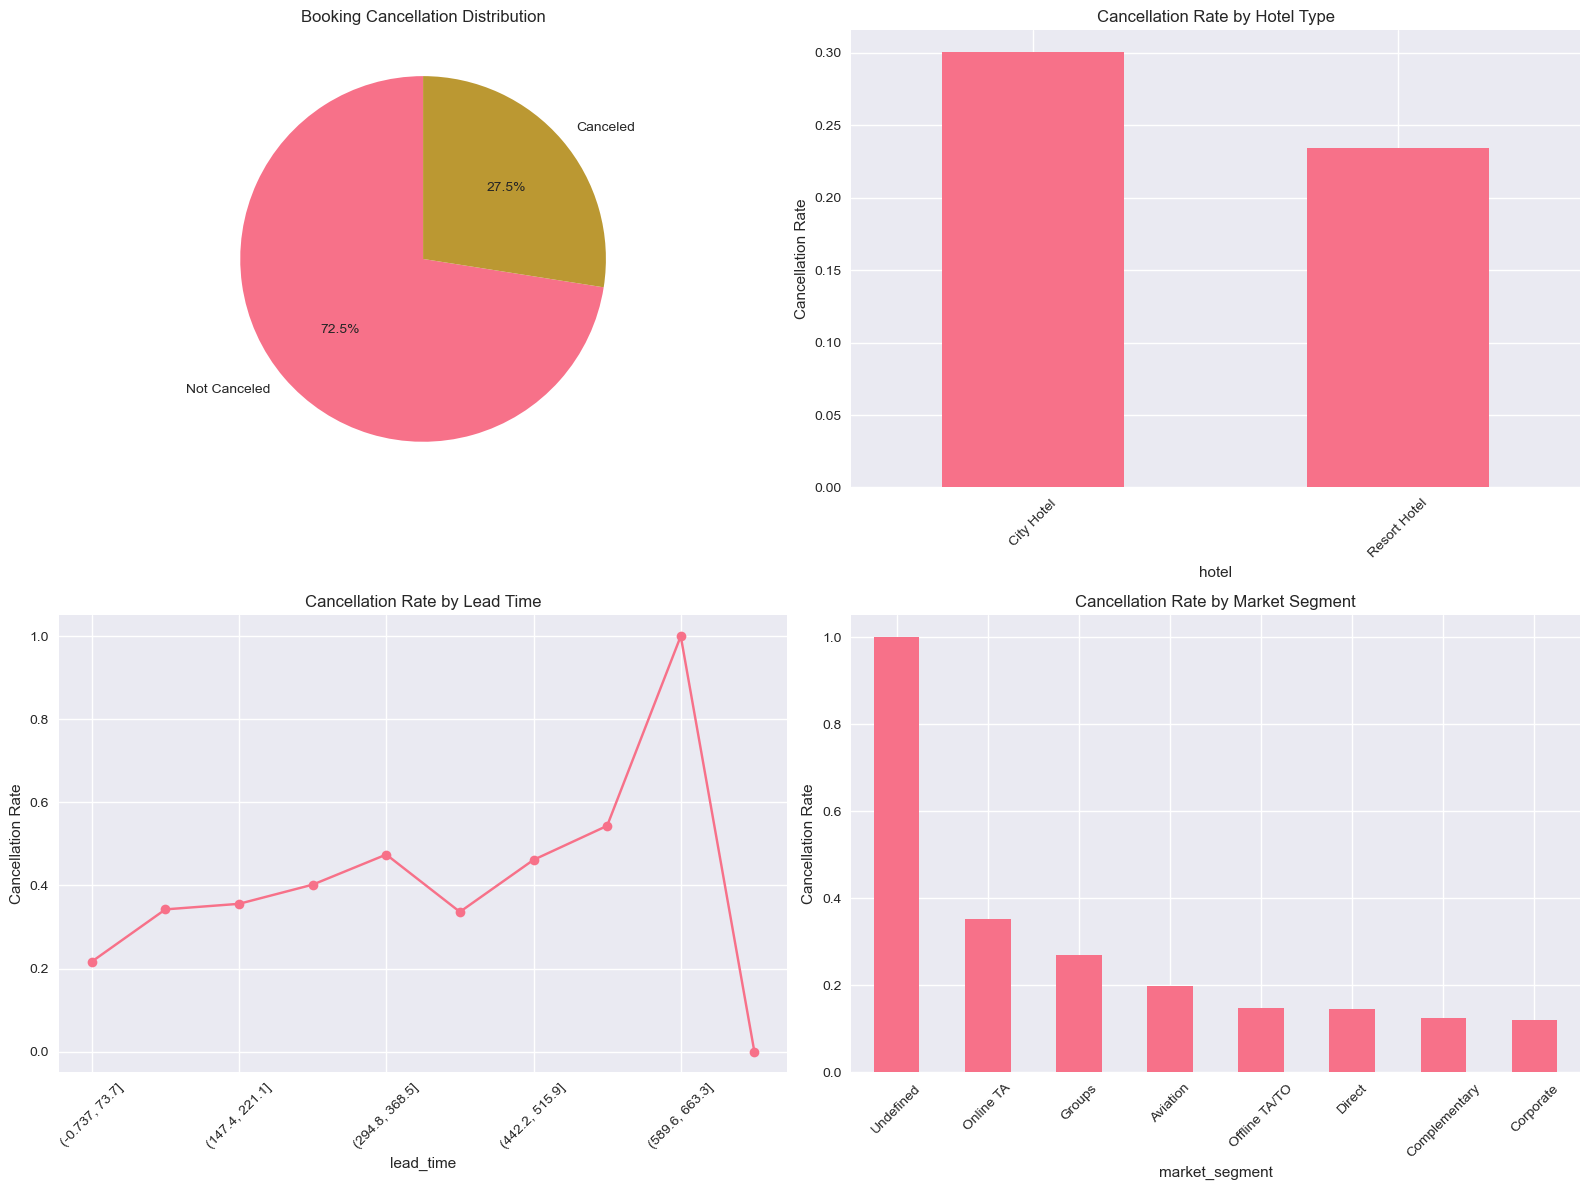


2️⃣ Temporal Analysis...


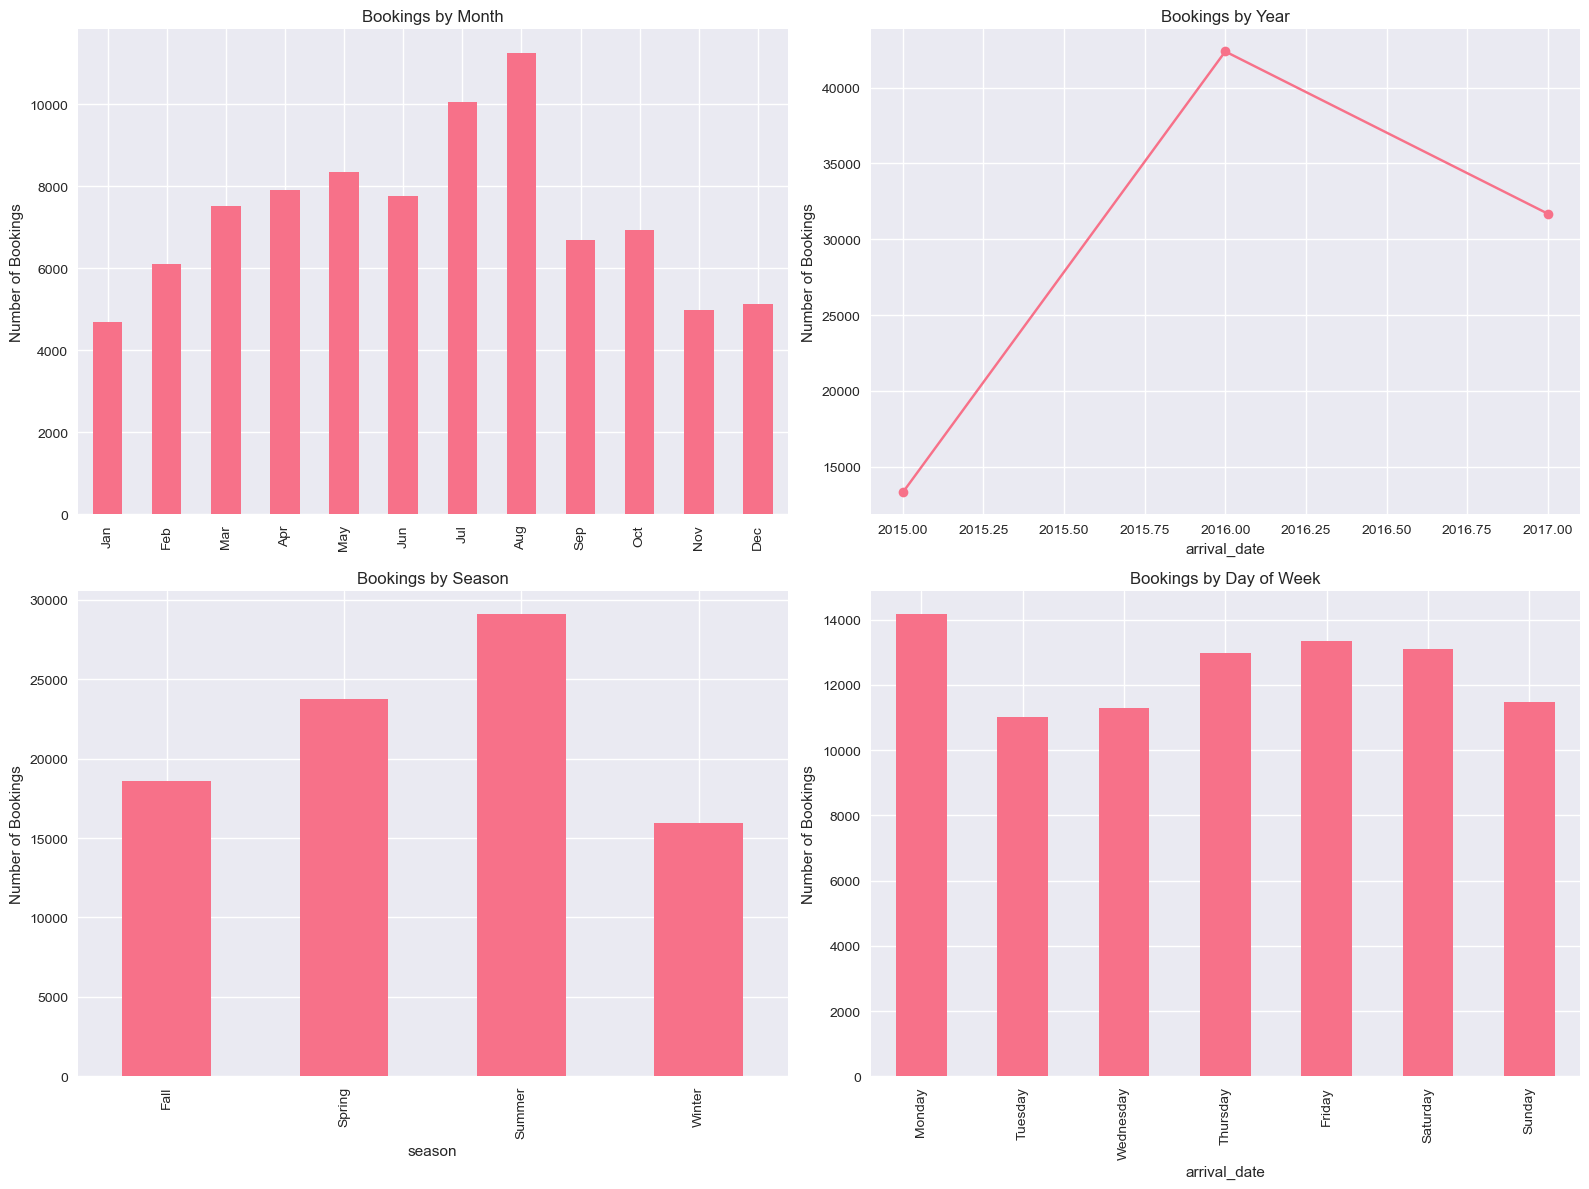


3️⃣ Guest and Revenue Analysis...


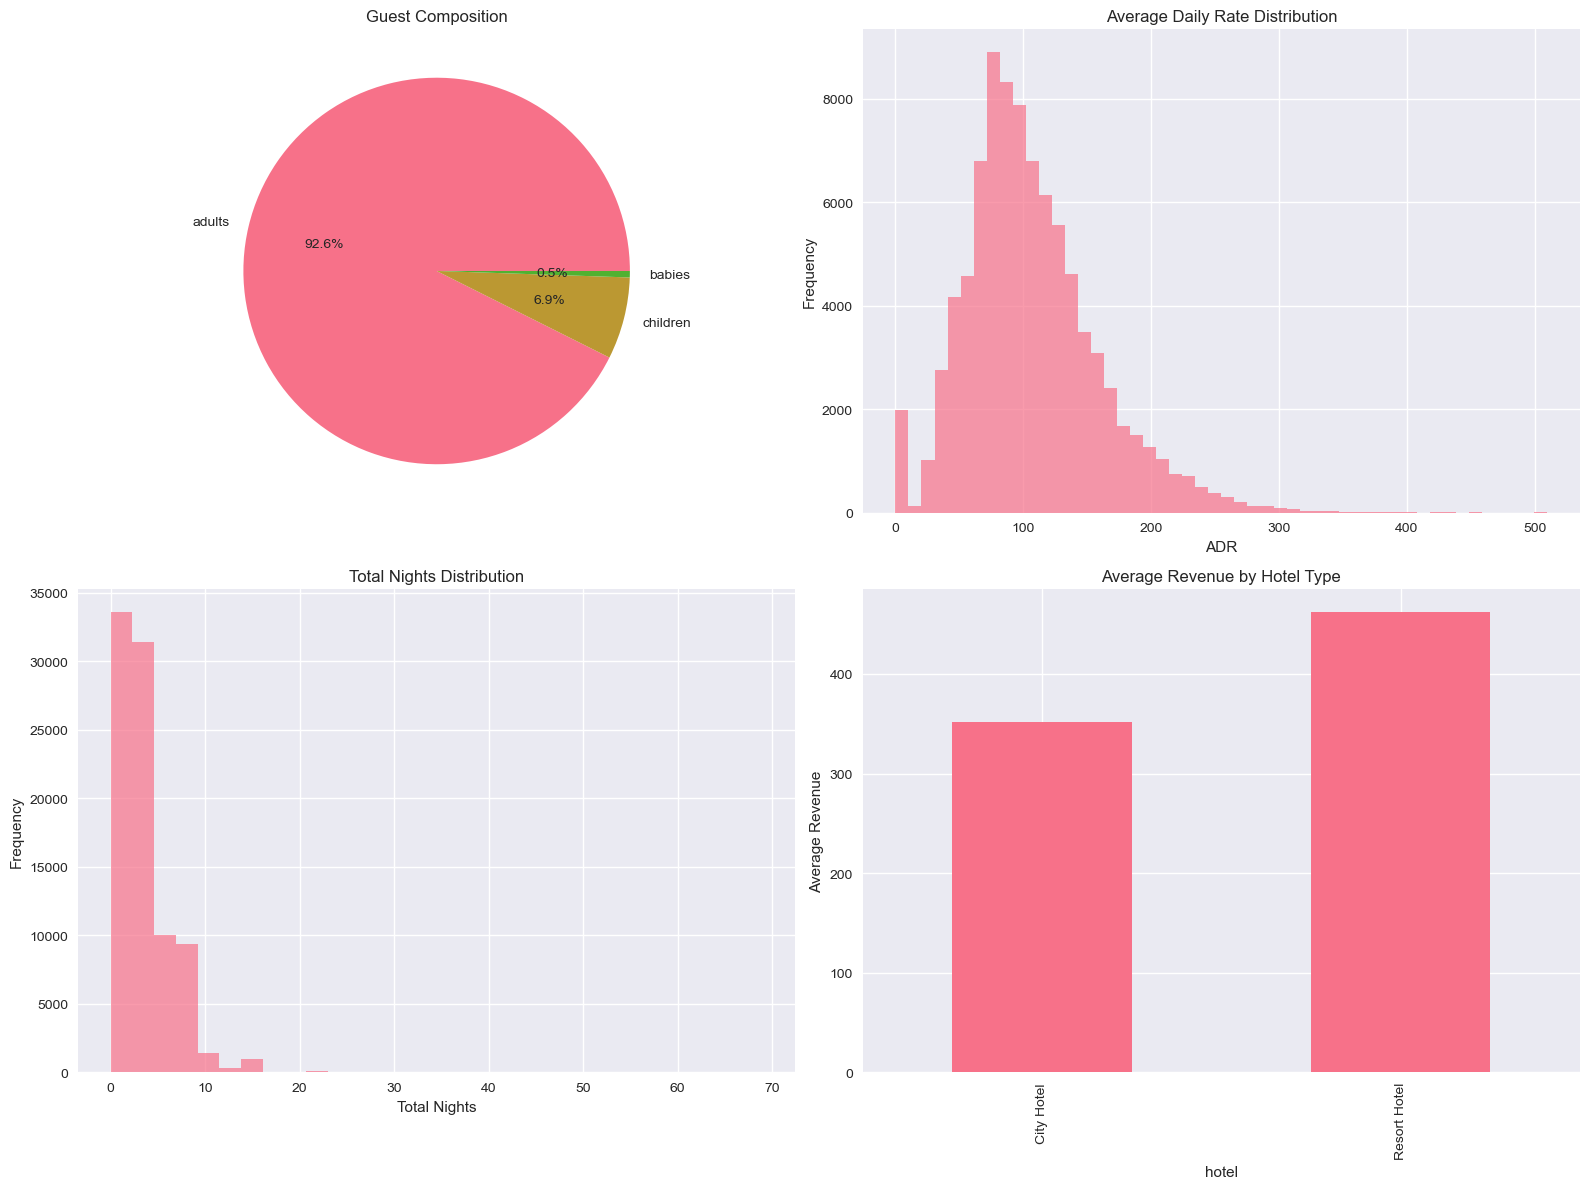


4️⃣ Geographic Analysis...


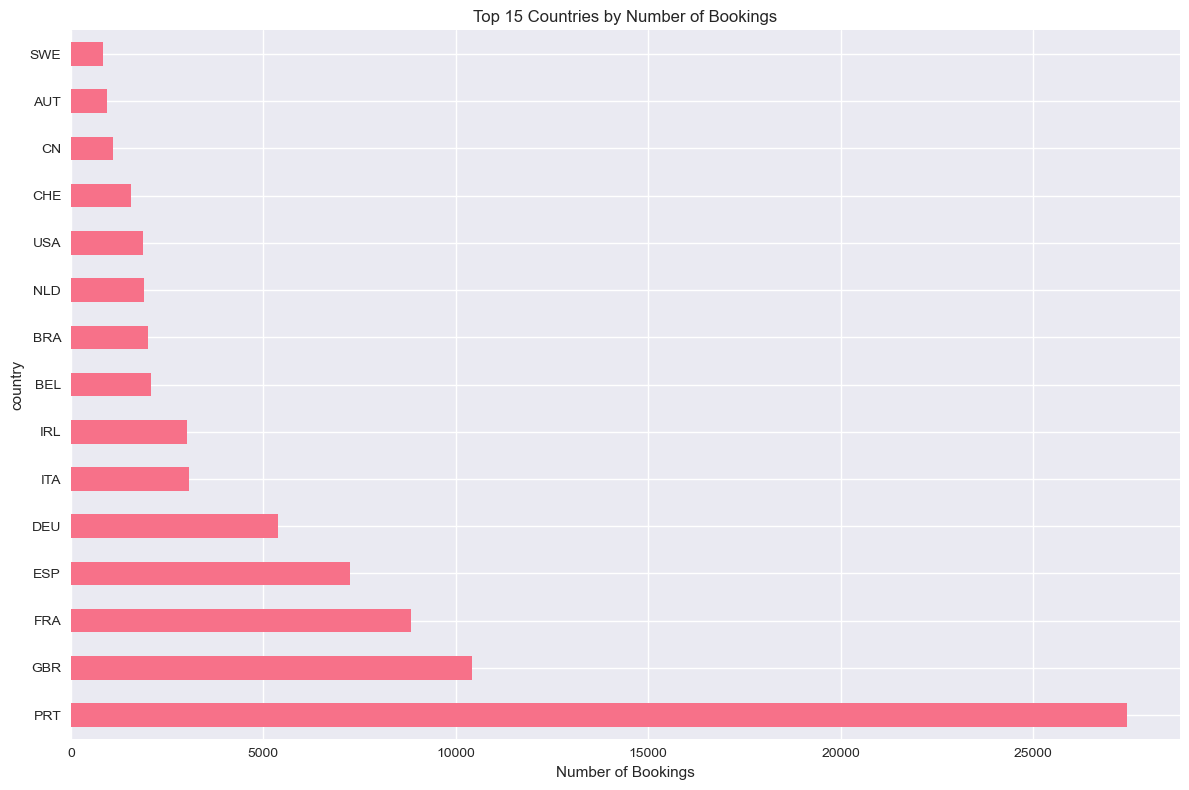

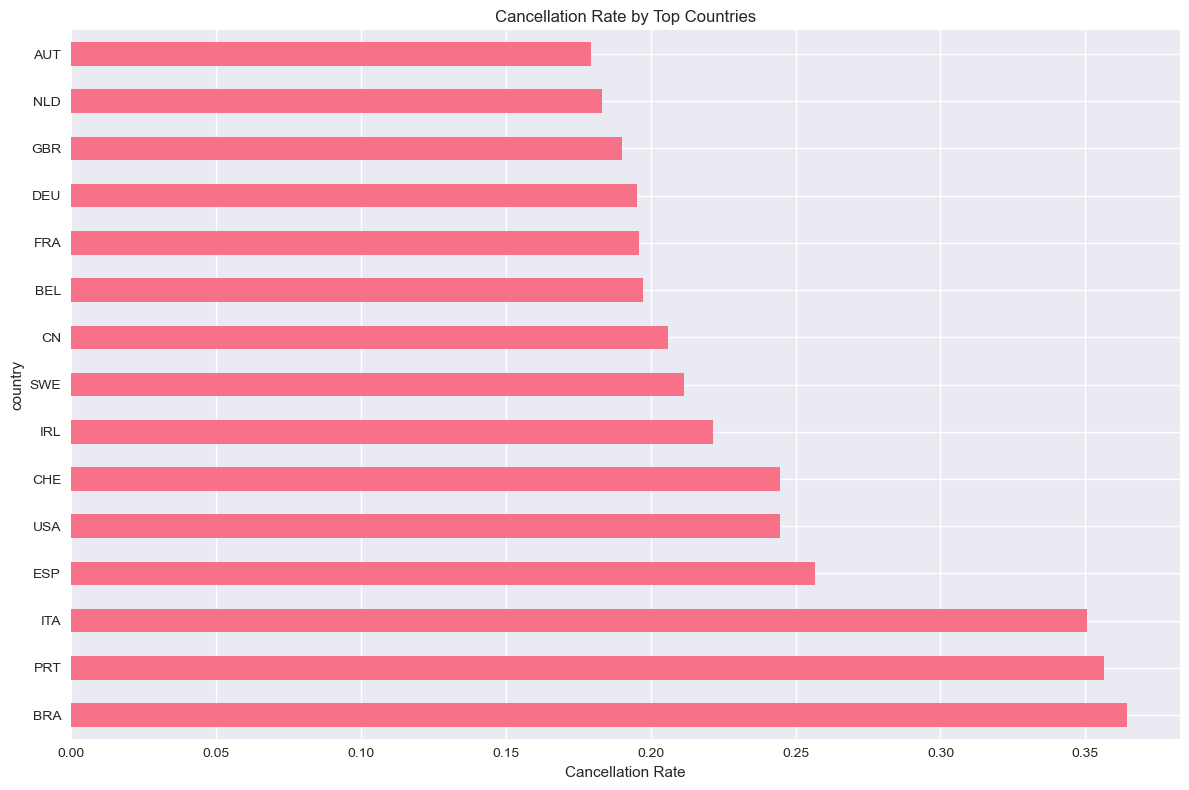


5️⃣ Correlation Analysis...


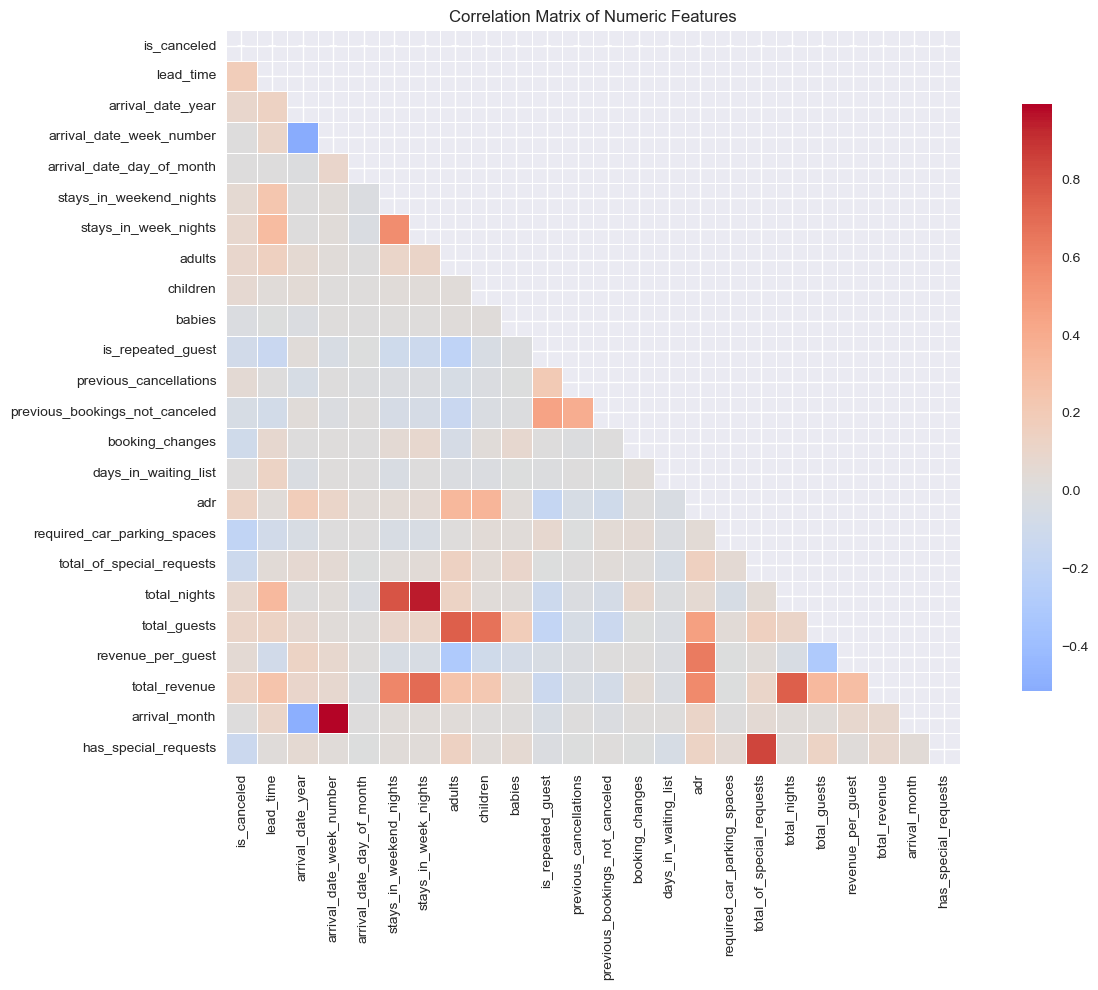


🎯 TOP 10 FEATURES CORRELATED WITH CANCELLATION:
   • lead_time: 0.184
   • required_car_parking_spaces: 0.184
   • total_revenue: 0.140
   • adr: 0.134
   • has_special_requests: 0.128
   • total_of_special_requests: 0.120
   • total_guests: 0.103
   • booking_changes: 0.094
   • is_repeated_guest: 0.090
   • arrival_date_year: 0.088


In [31]:

# =============================================================================
# 📊 SECTION 3: EXPLORATORY DATA ANALYSIS
# =============================================================================

def perform_eda(df):
    """Comprehensive Exploratory Data Analysis"""
    print("\n📊 EXPLORATORY DATA ANALYSIS")
    print("-" * 40)
    
    # 1. Target Variable Analysis
    print("1️⃣ Target Variable Analysis...")
    
    if 'is_canceled' in df.columns:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Cancellation distribution
        cancel_counts = df['is_canceled'].value_counts()
        axes[0, 0].pie(cancel_counts.values, labels=['Not Canceled', 'Canceled'], 
                      autopct='%1.1f%%', startangle=90)
        axes[0, 0].set_title('Booking Cancellation Distribution')
        
        # Cancellation by hotel type
        if 'hotel' in df.columns:
            cancel_by_hotel = df.groupby('hotel')['is_canceled'].agg(['count', 'mean'])
            cancel_by_hotel['mean'].plot(kind='bar', ax=axes[0, 1])
            axes[0, 1].set_title('Cancellation Rate by Hotel Type')
            axes[0, 1].set_ylabel('Cancellation Rate')
            axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Cancellation by lead time
        if 'lead_time' in df.columns:
            # Bin lead time for better visualization
            lead_time_bins = pd.cut(df['lead_time'], bins=10)
            cancel_by_lead = df.groupby(lead_time_bins)['is_canceled'].mean()
            cancel_by_lead.plot(kind='line', marker='o', ax=axes[1, 0])
            axes[1, 0].set_title('Cancellation Rate by Lead Time')
            axes[1, 0].set_ylabel('Cancellation Rate')
            axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Cancellation by market segment
        if 'market_segment' in df.columns:
            cancel_by_segment = df.groupby('market_segment')['is_canceled'].mean().sort_values(ascending=False)
            cancel_by_segment.plot(kind='bar', ax=axes[1, 1])
            axes[1, 1].set_title('Cancellation Rate by Market Segment')
            axes[1, 1].set_ylabel('Cancellation Rate')
            axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    # 2. Temporal Analysis
    print("\n2️⃣ Temporal Analysis...")
    
    if 'arrival_date' in df.columns:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Monthly booking patterns
        monthly_bookings = df.groupby(df['arrival_date'].dt.month).size()
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        monthly_bookings.index = [month_names[i-1] for i in monthly_bookings.index]
        monthly_bookings.plot(kind='bar', ax=axes[0, 0])
        axes[0, 0].set_title('Bookings by Month')
        axes[0, 0].set_ylabel('Number of Bookings')
        
        # Yearly trends
        yearly_bookings = df.groupby(df['arrival_date'].dt.year).size()
        yearly_bookings.plot(kind='line', marker='o', ax=axes[0, 1])
        axes[0, 1].set_title('Bookings by Year')
        axes[0, 1].set_ylabel('Number of Bookings')
        
        # Seasonal patterns
        if 'season' in df.columns:
            seasonal_bookings = df.groupby('season').size()
            seasonal_bookings.plot(kind='bar', ax=axes[1, 0])
            axes[1, 0].set_title('Bookings by Season')
            axes[1, 0].set_ylabel('Number of Bookings')
        
        # Day of week patterns
        dow_bookings = df.groupby(df['arrival_date'].dt.day_name()).size()
        dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        dow_bookings = dow_bookings.reindex(dow_order)
        dow_bookings.plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_title('Bookings by Day of Week')
        axes[1, 1].set_ylabel('Number of Bookings')
        
        plt.tight_layout()
        plt.show()
    
    # 3. Guest and Revenue Analysis
    print("\n3️⃣ Guest and Revenue Analysis...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Guest composition
    if all(col in df.columns for col in ['adults', 'children', 'babies']):
        guest_composition = df[['adults', 'children', 'babies']].sum()
        guest_composition.plot(kind='pie', ax=axes[0, 0], autopct='%1.1f%%')
        axes[0, 0].set_title('Guest Composition')
    
    # ADR distribution
    if 'adr' in df.columns:
        df['adr'].hist(bins=50, ax=axes[0, 1], alpha=0.7)
        axes[0, 1].set_title('Average Daily Rate Distribution')
        axes[0, 1].set_xlabel('ADR')
        axes[0, 1].set_ylabel('Frequency')
    
    # Total nights distribution
    if 'total_nights' in df.columns:
        df['total_nights'].hist(bins=30, ax=axes[1, 0], alpha=0.7)
        axes[1, 0].set_title('Total Nights Distribution')
        axes[1, 0].set_xlabel('Total Nights')
        axes[1, 0].set_ylabel('Frequency')
    
    # Revenue by hotel type
    if all(col in df.columns for col in ['hotel', 'total_revenue']):
        revenue_by_hotel = df.groupby('hotel')['total_revenue'].mean()
        revenue_by_hotel.plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_title('Average Revenue by Hotel Type')
        axes[1, 1].set_ylabel('Average Revenue')
    
    plt.tight_layout()
    plt.show()
    
    # 4. Geographic Analysis
    print("\n4️⃣ Geographic Analysis...")
    
    if 'country' in df.columns:
        # Top countries by bookings
        top_countries = df['country'].value_counts().head(15)
        
        plt.figure(figsize=(12, 8))
        top_countries.plot(kind='barh')
        plt.title('Top 15 Countries by Number of Bookings')
        plt.xlabel('Number of Bookings')
        plt.tight_layout()
        plt.show()
        
        # Cancellation rate by top countries
        if 'is_canceled' in df.columns:
            top_countries_list = top_countries.index.tolist()
            cancel_by_country = df[df['country'].isin(top_countries_list)].groupby('country')['is_canceled'].mean().sort_values(ascending=False)
            
            plt.figure(figsize=(12, 8))
            cancel_by_country.plot(kind='barh')
            plt.title('Cancellation Rate by Top Countries')
            plt.xlabel('Cancellation Rate')
            plt.tight_layout()
            plt.show()
    
    # 5. Correlation Analysis
    print("\n5️⃣ Correlation Analysis...")
    
    # Select numeric columns for correlation
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    if len(numeric_cols) > 1:
        plt.figure(figsize=(14, 10))
        
        # Calculate correlation matrix
        corr_matrix = df[numeric_cols].corr()
        
        # Create heatmap
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
                   cmap='coolwarm', center=0, square=True, 
                   linewidths=0.5, cbar_kws={"shrink": 0.8})
        plt.title('Correlation Matrix of Numeric Features')
        plt.tight_layout()
        plt.show()
        
        # Show strongest correlations with target variable
        if 'is_canceled' in numeric_cols:
            target_corr = corr_matrix['is_canceled'].abs().sort_values(ascending=False)[1:11]  # Top 10 excluding self
            print(f"\n🎯 TOP 10 FEATURES CORRELATED WITH CANCELLATION:")
            for feature, corr in target_corr.items():
                print(f"   • {feature}: {corr:.3f}")
    
    return df

# Perform EDA
if 'df_clean' in locals():
    df_analyzed = perform_eda(df_clean)


In [32]:

# =============================================================================
# 🤖 SECTION 4: MACHINE LEARNING MODEL DEVELOPMENT
# =============================================================================

def prepare_features_for_modeling(df):
    """Prepare features for machine learning"""
    print("\n🤖 PREPARING FEATURES FOR MODELING")
    print("-" * 40)
    
    # Create a copy for modeling
    df_model = df.copy()
    
    # Define features to exclude (target variable and leaky features)
    exclude_features = [
        'is_canceled',  # Target variable
        'reservation_status',  # Leaky - directly related to cancellation
        'reservation_status_date',  # Leaky - date information
        'arrival_date',  # Date feature (we'll use engineered features instead)
        'arrival_date_year',  # Redundant with arrival_date
        'arrival_date_month',  # Redundant with season
        'arrival_date_day_of_month'  # Less important
    ]
    
    # Get feature columns
    feature_cols = [col for col in df_model.columns if col not in exclude_features]
    
    print(f"📊 Feature preparation:")
    print(f"   • Total features available: {len(df_model.columns)}")
    print(f"   • Features excluded: {len(exclude_features)}")
    print(f"   • Features for modeling: {len(feature_cols)}")
    
    # Separate features and target
    X = df_model[feature_cols].copy()
    y = df_model['is_canceled'] if 'is_canceled' in df_model.columns else None
    
    # Handle categorical variables
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=[np.number]).columns
    
    print(f"   • Categorical features: {len(categorical_cols)}")
    print(f"   • Numerical features: {len(numerical_cols)}")
    
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        print(f"   ✅ Encoded: {col}")
    
    return X, y, label_encoders, feature_cols

def train_multiple_models(X, y):
    """Train and compare multiple machine learning models"""
    print("\n🎯 TRAINING MULTIPLE MODELS")
    print("-" * 40)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"📊 Data split:")
    print(f"   • Training set: {X_train.shape[0]:,} samples")
    print(f"   • Test set: {X_test.shape[0]:,} samples")
    print(f"   • Features: {X_train.shape[1]}")
    
    # Define models to compare
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100, 
            max_depth=10, 
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            random_state=42,
            class_weight='balanced',
            max_iter=1000
        )
    }
    
    # Train and evaluate models
    model_results = {}
    trained_models = {}
    
    for name, model in models.items():
        print(f"\n🔄 Training {name}...")
        
        # Train the model
        model.fit(X_train, y_train)
        trained_models[name] = model
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        
        model_results[name] = {
            'accuracy': accuracy,
            'auc_score': auc_score,
            'f1_score': f1,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"   ✅ {name} completed")
        print(f"      • Accuracy: {accuracy:.4f}")
        print(f"      • AUC Score: {auc_score:.4f}")
        print(f"      • F1 Score: {f1:.4f}")
        print(f"      • CV AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    return trained_models, model_results, X_train, X_test, y_train, y_test

def evaluate_best_model(models, results, X_test, y_test, feature_names):
    """Detailed evaluation of the best performing model"""
    print("\n🏆 BEST MODEL EVALUATION")
    print("-" * 40)
    
    # Find best model based on AUC score
    best_model_name = max(results.keys(), key=lambda x: results[x]['auc_score'])
    best_model = models[best_model_name]
    best_results = results[best_model_name]
    
    print(f"🥇 Best Model: {best_model_name}")
    print(f"   • AUC Score: {best_results['auc_score']:.4f}")
    print(f"   • Accuracy: {best_results['accuracy']:.4f}")
    print(f"   • F1 Score: {best_results['f1_score']:.4f}")
    
    # Detailed classification report
    print(f"\n📊 DETAILED CLASSIFICATION REPORT:")
    print(classification_report(y_test, best_results['y_pred']))
    
    # Create comprehensive evaluation plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Model comparison
    model_names = list(results.keys())
    auc_scores = [results[name]['auc_score'] for name in model_names]
    
    axes[0, 0].bar(model_names, auc_scores)
    axes[0, 0].set_title('Model Comparison (AUC Score)')
    axes[0, 0].set_ylabel('AUC Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Confusion Matrix
    cm = confusion_matrix(y_test, best_results['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
    axes[0, 1].set_title(f'Confusion Matrix - {best_model_name}')
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Actual')
    
    # 3. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, best_results['y_pred_proba'])
    axes[0, 2].plot(fpr, tpr, label=f'ROC Curve (AUC = {best_results["auc_score"]:.3f})')
    axes[0, 2].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[0, 2].set_xlabel('False Positive Rate')
    axes[0, 2].set_ylabel('True Positive Rate')
    axes[0, 2].set_title('ROC Curve')
    axes[0, 2].legend()
    
    #